In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

---

General variables and dictionaries

In [2]:
VARIABLE = 'MonthlyIncome'
COMPARE_METRIC = 'waic' # metric for comparing the models, options are 'waic' or 'loo'

ALPHA_LEVEL = 0.05

J = 6 # Number of regions
K = 3 # Number of educational levels

In [3]:
RegionsToNumbers = {
    'NorthernThailand': 0
    , 'SouthernThailand': 2
    , 'WesternThailand': 3
    , 'EasternThailand': 5
    , 'NortheastThailand': 1
    , 'CentralThailand': 4
}

In [4]:
NumbersToRegions = {
    0: 'Northern Thailand'
    , 2: 'Southern Thailand'
    , 3: 'Western Thailand'
    , 5: 'Eastern Thailand'
    , 1: 'Northeast Thailand'
    , 4: 'Central Thailand'
}

---

Read the data and give it the basic needed structure

In [5]:
ProvincesProvinceIdRegion = pd.read_csv("../../../Data/Enriched/ProvincesProvinceIdRegion.csv")

In [6]:
DatEduLow = pd.read_csv("../../../Data/Processed/DataProvinceEducationalLevelLow.csv")
DatEduLow = pd.merge(DatEduLow, ProvincesProvinceIdRegion)
DatEduLow['RegionNumber'] = DatEduLow['Region'].replace(RegionsToNumbers)
DatEduLow['EducationalLevel'] = 0

DatEduMid = pd.read_csv("../../../Data/Processed/DataProvinceEducationalLevelMid.csv")
DatEduMid = pd.merge(DatEduMid, ProvincesProvinceIdRegion)
DatEduMid['RegionNumber'] = DatEduMid['Region'].replace(RegionsToNumbers)
DatEduMid['EducationalLevel'] = 1

DatEduHigh = pd.read_csv("../../../Data/Processed/DataProvinceEducationalLevelHigh.csv")
DatEduHigh = pd.merge(DatEduHigh, ProvincesProvinceIdRegion)
DatEduHigh['RegionNumber'] = DatEduHigh['Region'].replace(RegionsToNumbers)
DatEduHigh['EducationalLevel'] = 2

Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")
Dat = pd.merge(Dat, ProvincesProvinceIdRegion)
Dat['RegionNumber'] = Dat['Region'].replace(RegionsToNumbers)

In [7]:
DatEdu = pd.concat([DatEduLow, DatEduMid, DatEduHigh]).reset_index(drop=True)
DatEdu = DatEdu[[VARIABLE + 'Mean', 'EducationalLevel', 'RegionNumber']]

DatEduLow = DatEduLow[[VARIABLE + 'Mean', 'RegionNumber']]
DatEduMid = DatEduMid[[VARIABLE + 'Mean', 'RegionNumber']]
DatEduHigh = DatEduHigh[[VARIABLE + 'Mean', 'RegionNumber']]

Dat = Dat[[VARIABLE + 'Mean', 'RegionNumber']]

---

Calculate the statistics per region and educational level

In [8]:
DatRegionEdu = DatEdu[
    [VARIABLE + 'Mean', 'RegionNumber', 'EducationalLevel']
].groupby(['RegionNumber', 'EducationalLevel']).agg(['count', 'mean', 'std']).reset_index()

DatRegionEdu.columns = DatRegionEdu.columns.droplevel()

DatRegionEdu = DatRegionEdu.rename(
    columns={
        'count': 'NumberObservations'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'
    }
)

DatRegionEdu.columns.values[0] = "RegionNumber"
DatRegionEdu.columns.values[1] = "EducationalLevel"

Calculate the statistics per region for each educational level and all the data

In [9]:
DatRegionEduLow = DatEduLow[[VARIABLE + 'Mean', 'RegionNumber']].groupby('RegionNumber').agg(['mean', 'std']).reset_index()
DatRegionEduMid = DatEduMid[[VARIABLE + 'Mean', 'RegionNumber']].groupby('RegionNumber').agg(['mean', 'std']).reset_index()
DatRegionEduHigh = DatEduHigh[[VARIABLE + 'Mean', 'RegionNumber']].groupby('RegionNumber').agg(['mean', 'std']).reset_index()

DatRegion = Dat[[VARIABLE + 'Mean', 'RegionNumber']].groupby('RegionNumber').agg(['mean', 'std']).reset_index()

def RenameColumnsDatRegion(df):
    df.columns = df.columns.droplevel()

    df = df.rename(
        columns={
            '':'RegionNumber'
            , 'mean': VARIABLE + 'Mean'
            , 'std': VARIABLE + 'Std'
        }
    )

    return df

DatRegionEduLow = RenameColumnsDatRegion(DatRegionEduLow)
DatRegionEduMid = RenameColumnsDatRegion(DatRegionEduMid)
DatRegionEduHigh = RenameColumnsDatRegion(DatRegionEduHigh)

DatRegion = RenameColumnsDatRegion(DatRegion)

---

Estimate $\nu$ for each educational level and the all the data

In [10]:
def EstimateNu(df):
    ES2 = (df[VARIABLE + 'Std']**2).mean()
    VS2 = (df[VARIABLE + 'Std']**2).var()

    HatNu = 2 * ES2**2 / VS2 + 4

    return HatNu

HatNuEdu = np.array([EstimateNu(df) for df in [DatRegionEduLow, DatRegionEduMid, DatRegionEduHigh, DatRegion]])

---

Declare the hierarchical model for each educational level and all data

In [11]:
def HierarchicalModelPerEducationalLevel(df=None, hatnu=None):
    with pm.Model() as ModelEstimatedNu:
        Rho    = pm.HalfFlat('Rho')
        pm.Potential('p(Rho)', -pm.math.log(Rho))

        Nu = pm.Exponential('Nu', lam=1/hatnu)

        Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
        Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

        Tau    = pm.HalfFlat('Tau')
        Mu     = pm.Flat('Mu')
        Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

        Income = pm.Normal('Income', mu=Theta[df['RegionNumber']], sigma=Sigma[df['RegionNumber']], observed=df[VARIABLE + 'Mean'])

    return ModelEstimatedNu

Adjust the model for each educational level and all data

In [12]:
ModelEduLow  = HierarchicalModelPerEducationalLevel(DatEduLow, HatNuEdu[0])
ModelEduMid  = HierarchicalModelPerEducationalLevel(DatEduMid, HatNuEdu[1])
ModelEduHigh = HierarchicalModelPerEducationalLevel(DatEduHigh, HatNuEdu[2])

ModelAllDat = HierarchicalModelPerEducationalLevel(Dat, HatNuEdu[3])

Get a sample from the posterior of each model

In [13]:
TraceEduLow  = pm.sample(model = ModelEduLow)
TraceEduMid  = pm.sample(model = ModelEduMid)
TraceEduHigh = pm.sample(model = ModelEduHigh)

TraceAllDat = pm.sample(model = ModelAllDat)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, Nu, Sigma2, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Get estimates to set hyperpriors

In [14]:
LambdaLow  = TraceEduLow.posterior.Mu - TraceAllDat.posterior.Mu
LambdaMid  = TraceEduMid.posterior.Mu - TraceAllDat.posterior.Mu
LambdaHigh = TraceEduHigh.posterior.Mu - TraceAllDat.posterior.Mu

HatMeanXi = np.array([LambdaLow.mean(), LambdaMid.mean(), LambdaHigh.mean()]).std()

HatMeanMuLow  = TraceEduLow.posterior.Mu.values.mean()
HatMeanMuMid  = TraceEduMid.posterior.Mu.values.mean()
HatMeanMuHigh = TraceEduHigh.posterior.Mu.values.mean()

HatMeanMu  = TraceAllDat.posterior.Mu.values.mean()
HatStdMu   = TraceAllDat.posterior.Mu.values.std()

HatMeanTau = TraceAllDat.posterior.Tau.values.mean()

---

In [15]:
with pm.Model() as ModelIncomeEducationalLevel:
    Tau   = pm.Exponential('Tau', lam = 1/HatMeanTau)
    Mu    = pm.Normal('Mu', mu = HatMeanMu, sigma = HatStdMu) # National average income
    Theta = pm.Normal('Theta', mu = Mu, sigma = Tau, shape = J) # Regional average income

    Add_Region = pm.Deterministic('Add_Region', Theta - Mu) # How much income is added by each region

    Xi     = pm.Exponential('Xi', lam = 1/HatMeanXi)
    Lambda = pm.Normal('Lambda', mu = 0, sigma = Xi, shape = K) # How much income is added by each educational level

    Eta = pm.Deterministic('Eta', Mu + Lambda) # Average income per educational level

    Diff_HighMid = pm.Deterministic('Diff_HighMid', Lambda[2] - Lambda[1]) # Difference in income between high and mid edu. level
    Diff_HighLow = pm.Deterministic('Diff_HighLow', Lambda[2] - Lambda[0]) # Difference in income between high and low edu. level
    Diff_MidLow  = pm.Deterministic('Diff_MidLow', Lambda[1] - Lambda[0]) # Difference in income between mid and low edu. level

    # Average income per region and educational level
    E = pm.Deterministic('E', Theta[DatEdu['RegionNumber']] + Lambda[DatEdu['EducationalLevel']]) 

    Rho = pm.HalfFlat('Rho', shape = K)
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam=HatNuEdu[:-1])

    Sigma2 = pm.InverseGamma('Sigma2', alpha = Nu/2, beta = Nu/2 * Rho**2, shape=(J,K))
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Income = pm.Normal(
        'Income'
        , mu = E
        , sigma = Sigma[DatEdu['RegionNumber'], DatEdu['EducationalLevel']]
        , observed = DatEdu['MonthlyIncomeMean']
    )

In [16]:
#pm.model_to_graphviz(ModelIncomeEducationalLevel)

In [17]:
with pm.Model() as ModelIncomeWithoutEducationalLevel:
    Tau   = pm.Exponential('Tau', lam = 1/HatMeanTau)
    Mu    = pm.Normal('Mu', mu = HatMeanMu, sigma = HatStdMu) # National average income
    Theta = pm.Normal('Theta', mu = Mu, sigma = Tau, shape = J) # Regional average income

    Rho = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam = HatNuEdu[-1])

    Sigma2 = pm.InverseGamma('Sigma2', alpha = Nu/2, beta = Nu/2 * Rho**2, shape = J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    Income = pm.Normal(
        'Income'
        , mu = Theta[DatEdu['RegionNumber']]
        , sigma = Sigma[DatEdu['RegionNumber']]
        , observed = DatEdu['MonthlyIncomeMean']
    )

Get a sample from the posterior and the posterior predictive

In [18]:
with ModelIncomeEducationalLevel:
    TraceIncomeEducationalLevel = pm.sample()
    TraceIncomeEducationalLevel.extend(pm.sample_posterior_predictive(TraceIncomeEducationalLevel))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tau, Mu, Theta, Xi, Lambda, Rho, Nu, Sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Income]


In [19]:
with ModelIncomeWithoutEducationalLevel:
    TraceIncomeWithoutEducationalLevel = pm.sample()
    TraceIncomeWithoutEducationalLevel.extend(pm.sample_posterior_predictive(TraceIncomeWithoutEducationalLevel))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tau, Mu, Theta, Rho, Nu, Sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [Income]


---

Calculate the WAIC of the model

In [20]:
pm.compute_log_likelihood(TraceIncomeEducationalLevel, model = ModelIncomeEducationalLevel)
pm.compute_log_likelihood(TraceIncomeWithoutEducationalLevel, model = ModelIncomeWithoutEducationalLevel)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [21]:
CompareTable = az.compare(
    {
        "Separate": TraceIncomeWithoutEducationalLevel
        , "Hierarchical": TraceIncomeEducationalLevel
    }
    , ic = COMPARE_METRIC
    , scale = 'deviance'
)

In [22]:
CompareTable.round(2)

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Hierarchical,0,4097.46,26.13,0.00,1.0,28.2,0.00,True,deviance
Separate,1,4662.59,6.33,565.13,0.0,14.7,28.62,True,deviance


---

Average national income, deviation between regions and deviation between educational levels

Text(0.5, 1.0, 'Deviation between educational levels, $\\xi$')

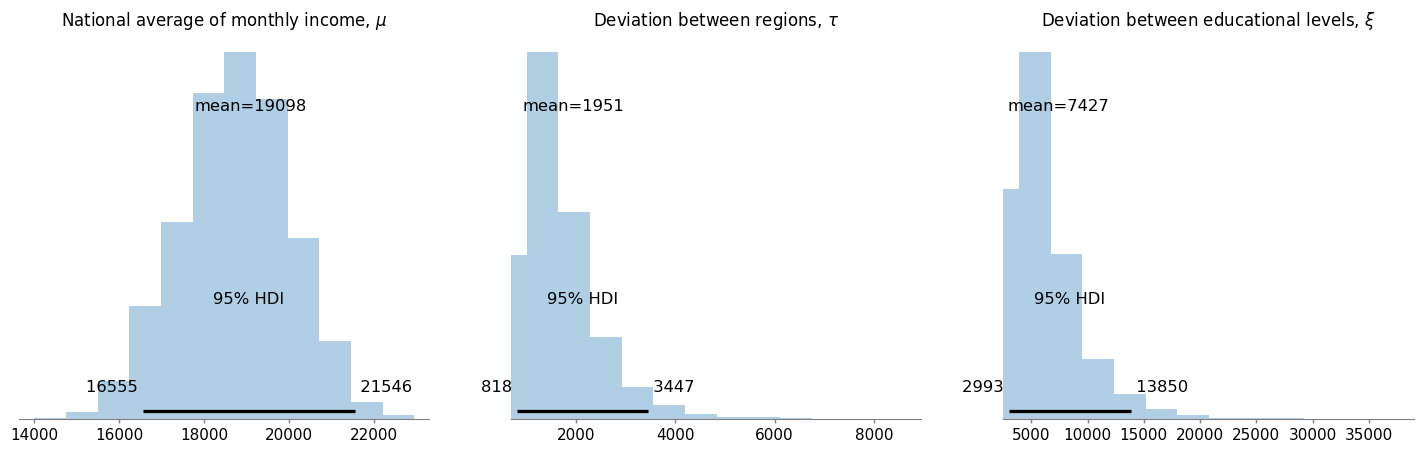

In [23]:
_, axes = plt.subplots(1,3, figsize=(18,5))

az.plot_posterior(
    TraceIncomeEducationalLevel
    , var_names = ['Mu', 'Tau', 'Xi']
    #, ref_val = [HatMeanMu, HatMeanTau, HatMeanXi]
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize = 11
    , ax = axes
)

axes[0].set_title(r"National average of monthly income, $\mu$")
axes[1].set_title(r"Deviation between regions, $\tau$")
axes[2].set_title(r"Deviation between educational levels, $\xi$")

Average income per educational level

Text(0.5, 0.98, 'Average monthly income per education level, $\\mu+\\lambda_k$')

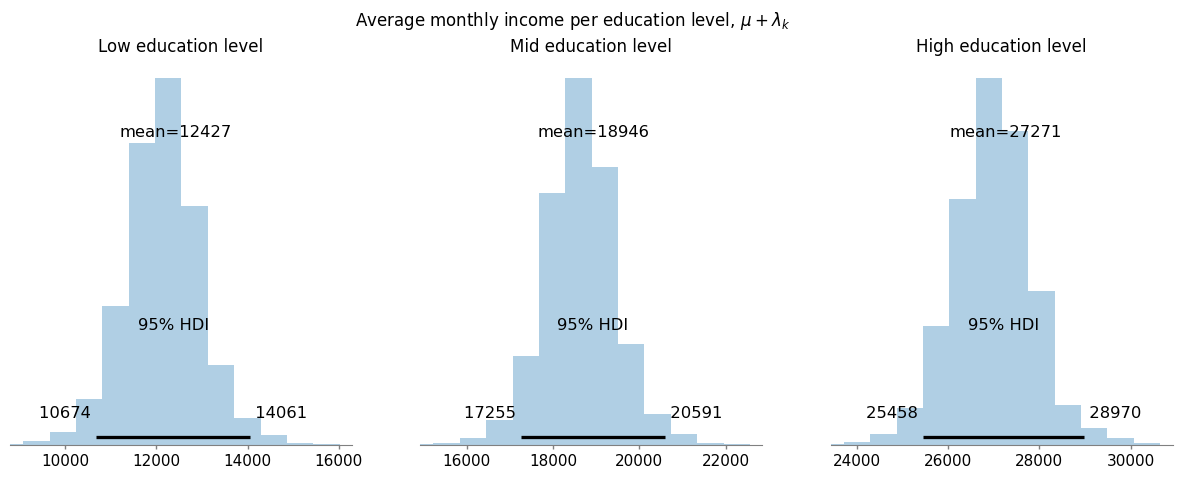

In [24]:
_, axes = plt.subplots(1,3, figsize=(15,5))

az.plot_posterior(
    TraceIncomeEducationalLevel
    , var_names=['Eta']
    #, ref_val=[HatMeanMuLow, HatMeanMuMid, HatMeanMuHigh]
    , hdi_prob=1-ALPHA_LEVEL
    , kind='hist'
    , textsize=11
    , ax=axes
)

axes[0].set_title("Low education level")
axes[1].set_title("Mid education level")
axes[2].set_title("High education level")

plt.suptitle(r"Average monthly income per education level, $\mu+\lambda_k$")

Difference between average income per educational level

Text(0.5, 0.98, "Difference in monthly income between different education levels, $\\lambda_k - \\lambda_{k'}$")

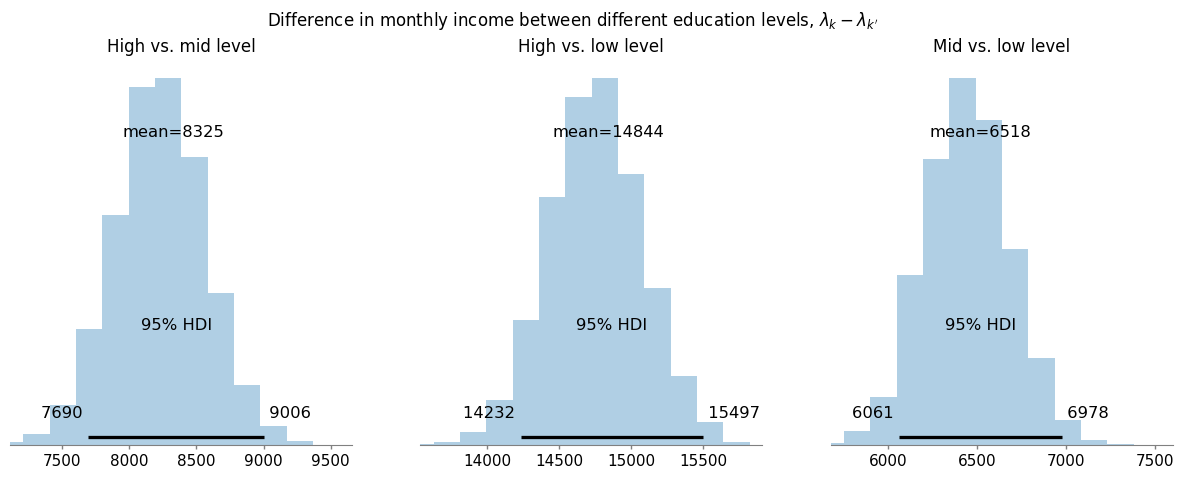

In [25]:
_, axes = plt.subplots(1,3, figsize=(15,5))

az.plot_posterior(
    TraceIncomeEducationalLevel
    , var_names=['^Diff']
    #, ref_val=[
    #    HatMeanMuHigh - HatMeanMuMid
    #    , HatMeanMuHigh - HatMeanMuLow
    #    , HatMeanMuMid - HatMeanMuLow
    #]
    , filter_vars='regex'
    , hdi_prob=1-ALPHA_LEVEL
    , kind='hist'
    , textsize=11
    , ax=axes
)

axes[0].set_title("High vs. mid level")
axes[1].set_title("High vs. low level")
axes[2].set_title("Mid vs. low level")

plt.suptitle(r"Difference in monthly income between different education levels, $\lambda_k - \lambda_{k'}$")

Average regional income

In [26]:
PosteriorMeanRegion = az.summary(
    TraceIncomeEducationalLevel
    , var_names ='Theta'
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
).reset_index(drop = True)

In [27]:
PosteriorMeanRegion = PosteriorMeanRegion.rename(
    columns = {
        'mean': 'HatTheta'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100)  + '%': 'LowTheta'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%': 'UppTheta'
    }
)

PosteriorMeanRegion = PosteriorMeanRegion[['HatTheta', 'LowTheta', 'UppTheta']]

In [28]:
DatRegion = pd.concat([DatRegion, PosteriorMeanRegion], axis=1)
DatRegion['Region'] = DatRegion['RegionNumber'].replace(NumbersToRegions)

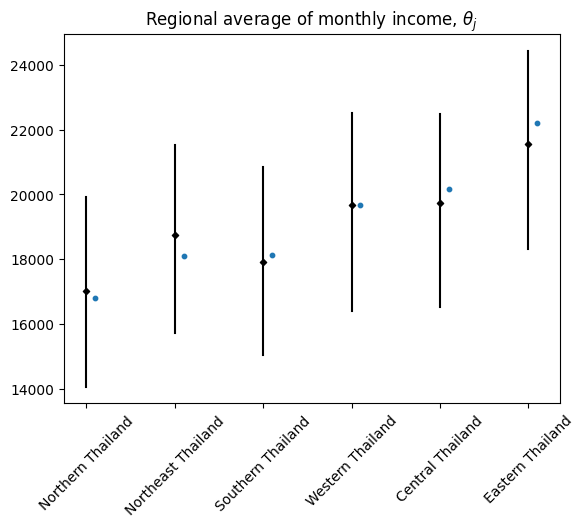

In [29]:
plt.scatter(range(J), DatRegion['HatTheta'], marker='D', color='k', s=10)
plt.scatter(np.arange(0.1, J+0.1, 1), DatRegion[VARIABLE + 'Mean'], marker='o', color='C0', s=10)

for j in range(J):
    plt.plot(
        [j, j],
        [DatRegion['LowTheta'][j], DatRegion['UppTheta'][j]],
        color='k'
    )

plt.title(r'Regional average of monthly income, $\theta_j$')
_ = plt.xticks(range(J), labels=DatRegion['Region'], rotation=45)

---

Explain average income by national income and how much is added per region and educational level

Text(0.5, 1.0, 'National average of monthly income, $\\mu$')

<Figure size 600x500 with 0 Axes>

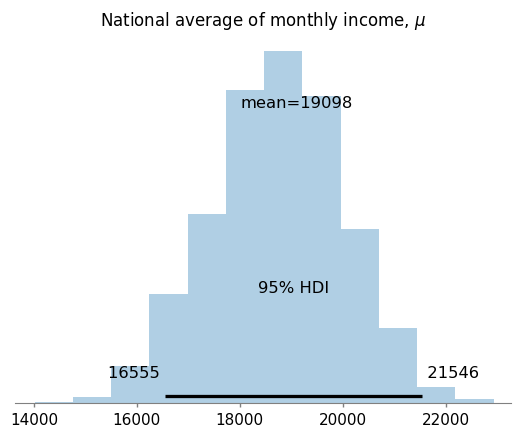

In [30]:
plt.figure(figsize=(6,5))

az.plot_posterior(
    TraceIncomeEducationalLevel
    , var_names = ['Mu']
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize=11
)

plt.title(r"National average of monthly income, $\mu$")

Text(0.5, 0.98, 'Average monthly income added per educational level, $\\lambda_k$')

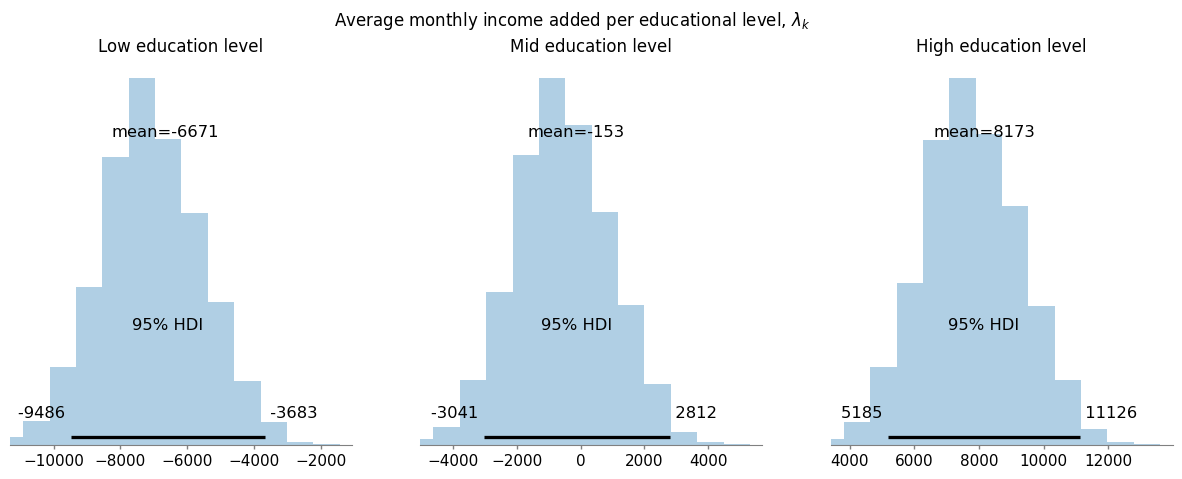

In [31]:
_, axes = plt.subplots(1,3, figsize=(15,5))

az.plot_posterior(
    TraceIncomeEducationalLevel
    , var_names=['Lambda']
    , hdi_prob=1-ALPHA_LEVEL
    , kind='hist'
    , textsize=11
    , ax=axes
)

axes[0].set_title("Low education level")
axes[1].set_title("Mid education level")
axes[2].set_title("High education level")

plt.suptitle(r"Average monthly income added per educational level, $\lambda_k$")

In [32]:
PosteriorAddRegion = az.summary(
    TraceIncomeEducationalLevel
    , var_names ='^Add'
    , filter_vars = 'regex'
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
).reset_index(drop = True)

PosteriorAddRegion = PosteriorAddRegion.rename(
    columns = {
        'mean': 'HatAddRegion'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100)  + '%': 'LowAddRegion'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%': 'UppAddRegion'
    }
)

PosteriorAddRegion = PosteriorAddRegion[['HatAddRegion', 'LowAddRegion', 'UppAddRegion']]

DatRegion = pd.concat([DatRegion, PosteriorAddRegion], axis=1)

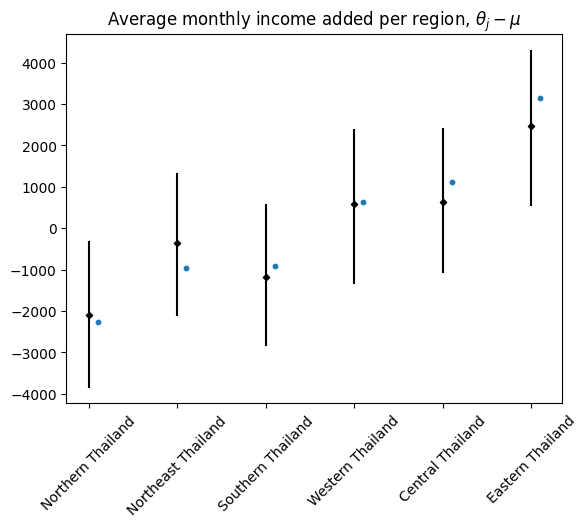

In [33]:
plt.scatter(range(J), DatRegion['HatAddRegion'], marker='D', color='k', s=10)
plt.scatter(np.arange(0.1, J+0.1, 1),  DatRegion[VARIABLE + 'Mean'] - HatMeanMu, marker='o', color='C0', s=10)

for j in range(J):
    plt.plot(
        [j, j],
        [DatRegion['LowAddRegion'][j], DatRegion['UppAddRegion'][j]],
        color='k'
    )

plt.title(r"Average monthly income added per region, $\theta_j - \mu$")
_ = plt.xticks(range(J), labels=DatRegion['Region'], rotation=45)

---

Average income per region and educational level

In [34]:
DatEdu['Region'] = DatEdu['RegionNumber'].replace(NumbersToRegions)

In [35]:
PosteriorMeanRegionEdu = az.summary(TraceIncomeEducationalLevel, var_names='E', kind='stats', hdi_prob=1-ALPHA_LEVEL)

In [36]:
DatEdu['HatE'] = PosteriorMeanRegionEdu['mean'].values
DatEdu['LowE'] = PosteriorMeanRegionEdu['hdi_' + str((ALPHA_LEVEL/2)*100)  + '%'].values
DatEdu['UppE'] = PosteriorMeanRegionEdu['hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%'].values

In [37]:
DatRegionEdu = pd.merge(
    DatRegionEdu
    , DatEdu.iloc[DatEdu[['RegionNumber', 'EducationalLevel']].drop_duplicates().index][
        ['RegionNumber', 'Region', 'EducationalLevel', 'HatE', 'LowE', 'UppE']
    ]
    , on = ['RegionNumber', 'EducationalLevel']
)

Text(0.5, 0.98, 'Average monthly income per region and education level, $\\theta_j + \\lambda_k$')

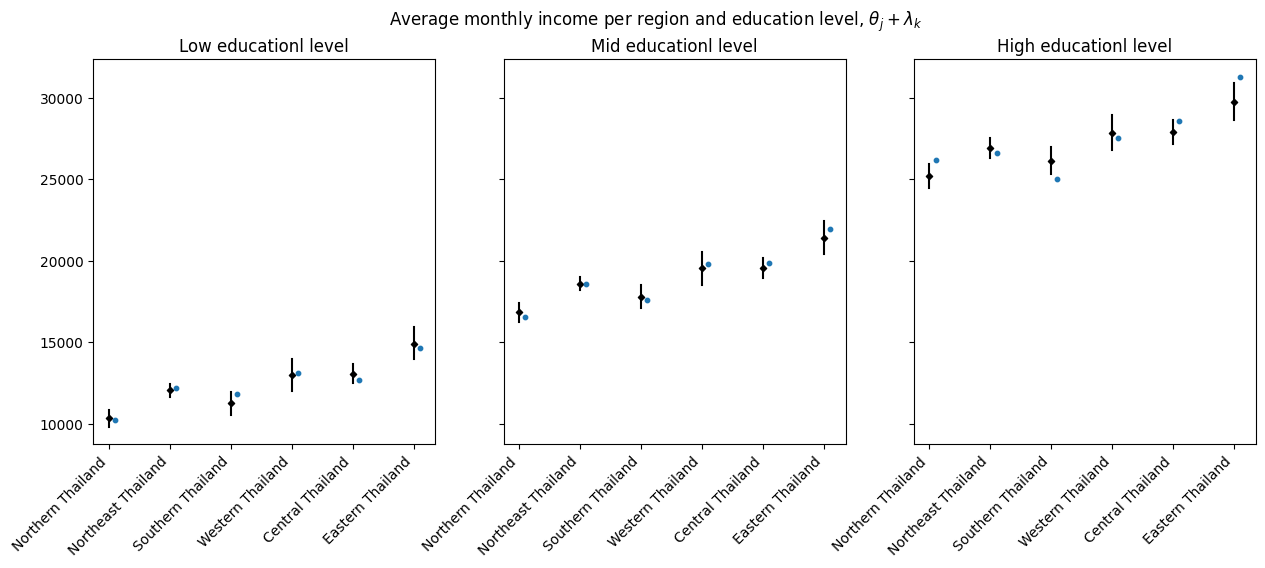

In [46]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))

for k, ax in enumerate(axs.reshape(-1)):
    Aux = DatRegionEdu[DatRegionEdu['EducationalLevel'] == k].reset_index(drop=True)

    ax.scatter(
        range(J)
        , Aux['HatE']
        , marker = 'D'
        , color = 'k'
        , s = 10
    )

    ax.scatter(
        np.arange(0.1, J + 0.1, 1)
        , Aux[VARIABLE + 'Mean']
        , marker = 'o'
        , color = 'C0'
        , s = 10
    )

    for j in range(J):
        ax.plot(
            [j, j],
            [Aux['LowE'][j], Aux['UppE'][j]],
            color = 'k'
        )

    ax.set_xticks(range(J))
    ax.set_xticklabels(Aux['Region'], rotation = 45, ha = 'right')

    if k == 0:
        ax.set_title("Low educationl level")
    elif k == 1:
        ax.set_title("Mid educationl level")
    else:
        ax.set_title("High educationl level")

fig.suptitle(r"Average monthly income per region and education level, $\theta_j + \lambda_k$")

Standard deviation per region and educational level

In [39]:
PosteriorSigmaRegionEdu = az.summary(
    TraceIncomeEducationalLevel
    , var_names ='Sigma'
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
).reset_index(drop = True)

PosteriorSigmaRegionEdu = PosteriorSigmaRegionEdu.rename(
    columns = {
        'mean': 'HatSigma'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100)  + '%': 'LowSigma'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%': 'UppSigma'
    }
)

PosteriorSigmaRegionEdu = PosteriorSigmaRegionEdu[['HatSigma', 'LowSigma', 'UppSigma']]

DatRegionEdu = pd.concat([DatRegionEdu, PosteriorSigmaRegionEdu], axis=1)

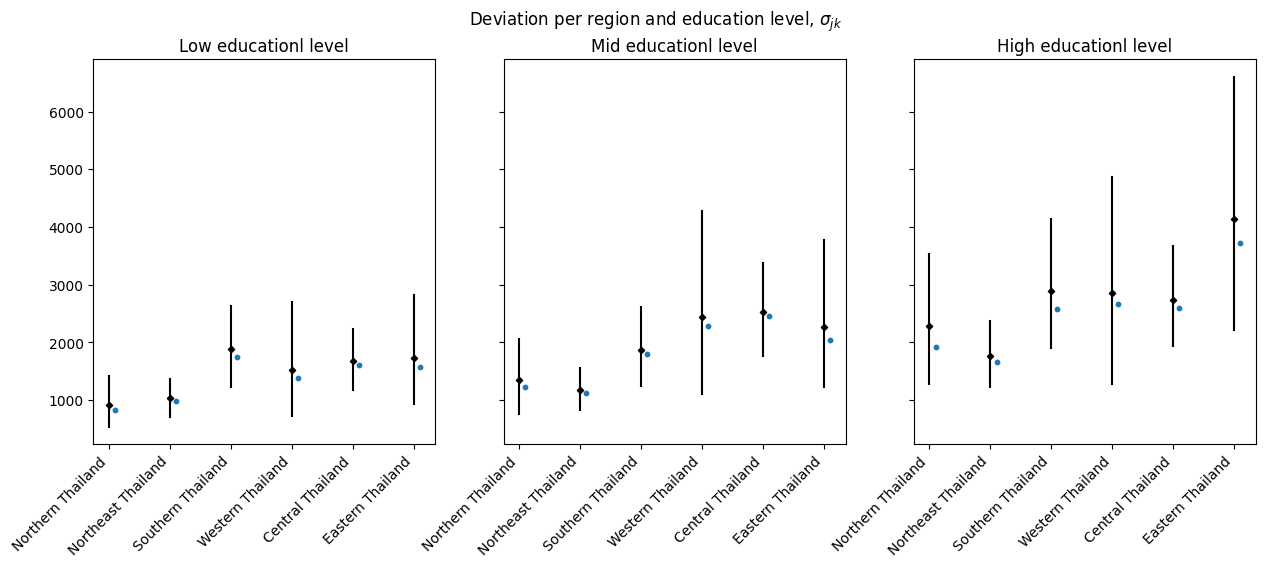

In [47]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))

for k, ax in enumerate(axs.reshape(-1)):
    Aux = DatRegionEdu[DatRegionEdu['EducationalLevel'] == k].reset_index(drop=True)

    ax.scatter(
        range(J)
        , Aux['HatSigma']
        , marker = 'D'
        , color = 'k'
        , s = 10
    )

    ax.scatter(
        np.arange(0.1, J + 0.1, 1)
        , Aux[VARIABLE + 'Std']
        , marker = 'o'
        , color = 'C0'
        , s = 10
    )

    for j in range(J):
        ax.plot(
            [j, j],
            [Aux['LowSigma'][j], Aux['UppSigma'][j]],
            color = 'k'
        )

    ax.set_xticks(range(J))
    ax.set_xticklabels(Aux['Region'], rotation = 45, ha = 'right')

    if k == 0:
        ax.set_title("Low educationl level")
    elif k == 1:
        ax.set_title("Mid educationl level")
    else:
        ax.set_title("High educationl level")
    
    fig.suptitle(r"Deviation per region and education level, $\sigma_{jk}$")

---

Posterior predictive

Text(0.5, 0, 'Monthly income')

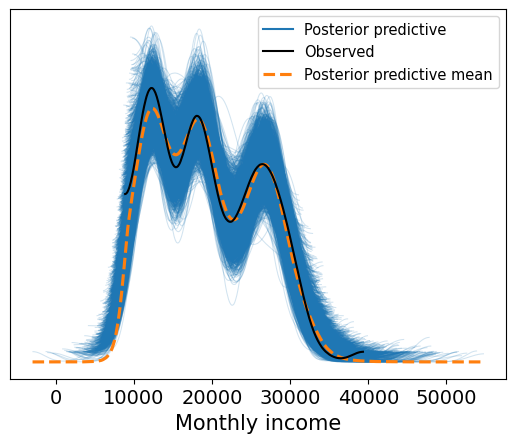

In [41]:
_, axes = plt.subplots(1,1)
az.plot_ppc(TraceIncomeEducationalLevel, ax=axes)
axes.set_xlabel("Monthly income")

In [42]:
PosteriorPredictiveSummary = az.summary(TraceIncomeEducationalLevel, group='posterior_predictive', hdi_prob=1-ALPHA_LEVEL, kind='stats')

In [43]:
DatEdu['HatY'] = PosteriorPredictiveSummary['mean'].values
DatEdu['LowY'] = PosteriorPredictiveSummary['hdi_' + str((ALPHA_LEVEL/2)*100) + '%'].values
DatEdu['UppY'] = PosteriorPredictiveSummary['hdi_' + str((1-ALPHA_LEVEL/2)*100) + '%'].values

In [44]:
DatRegionEdu = pd.merge(
    DatRegionEdu
    , DatEdu.iloc[DatEdu[['RegionNumber', 'EducationalLevel']].drop_duplicates().index][
        ['RegionNumber', 'EducationalLevel', 'HatY', 'LowY', 'UppY']
    ]
    , on = ['RegionNumber', 'EducationalLevel']
)

Text(0.5, 0.98, 'Monthly income per region and education level, $Y_{ijk}$')

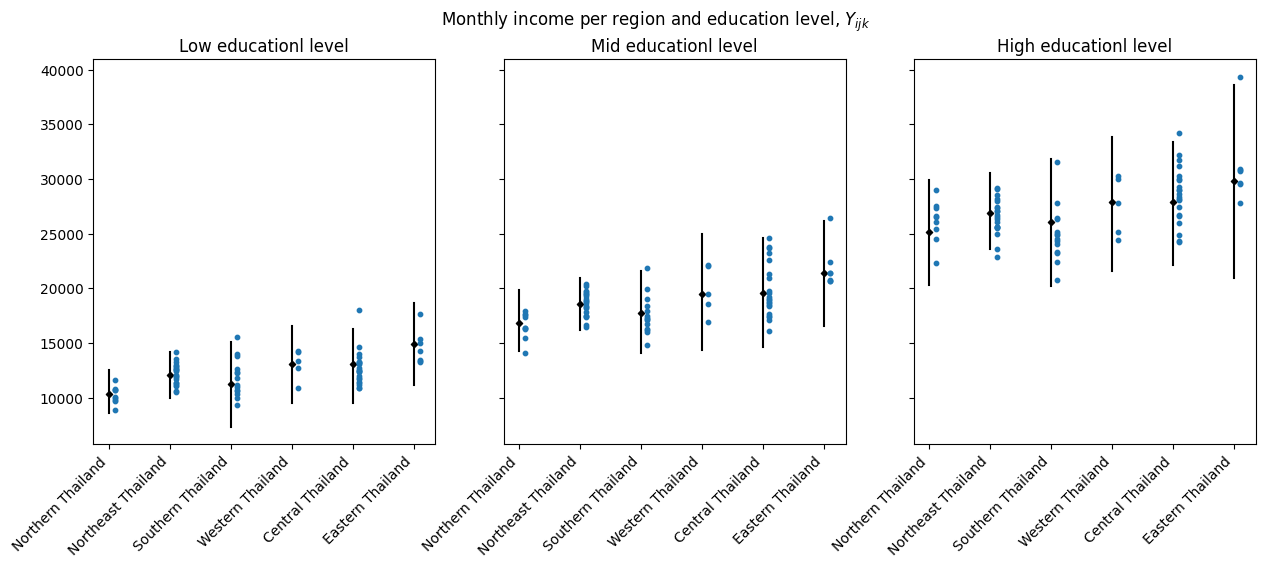

In [48]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))

for k, ax in enumerate(axs.reshape(-1)):
    Aux = DatRegionEdu[DatRegionEdu['EducationalLevel'] == k].reset_index(drop=True)
    Aux2 = DatEdu[DatEdu['EducationalLevel'] == k].reset_index(drop=True)

    ax.scatter(
        range(J)
        , Aux['HatY']
        , marker = 'D'
        , color = 'k'
        , s = 10
    )

    for j in range(J):
        ax.plot(
            [j, j],
            [Aux['LowY'][j], Aux['UppY'][j]],
            color='k'
        )

        ax.scatter(
            [j+0.1]*Aux.loc[Aux['Region'] == Aux['Region'][j], 'NumberObservations'][j]
            , Aux2[Aux2['Region'] == Aux['Region'][j]][VARIABLE + 'Mean']
            , marker='o'
            , color='C0'
            , s=10
            )

    ax.set_xticks(range(J))
    ax.set_xticklabels(Aux['Region'], rotation = 45, ha = 'right')

    if k == 0:
        ax.set_title("Low educationl level")
    elif k == 1:
        ax.set_title("Mid educationl level")
    else:
        ax.set_title("High educationl level")

fig.suptitle(r"Monthly income per region and education level, $Y_{ijk}$")